# Optimization-Induced Uncertainty

**Purpose:** Quantify how compiler optimization degrades alignment quality.
Three complementary views:

1. **Reason shift** — which *types* of alignment difficulty change between two
   selected optimization levels (configurable via `OPT_A` / `OPT_B` below).
2. **Overlap ECDF** — how the overlap ratio distribution shifts across all
   loaded optimization levels.
3. **Decision space scatter** — overlap vs gap in 2D across all opt levels,
   showing the joint distribution.

In [1]:
## ── Imports & Style ──────────────────────────────────────────────────────────

from pathlib import Path
import sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sys.path.insert(0, str(Path("../..").resolve()))

from data import (
    load_dataset, enrich_pairs, compute_verdict_rates, compute_reason_shift,
    AlignmentVerdict, OracleVerdict,
)

warnings.filterwarnings("ignore", category=FutureWarning)

PALETTE_VERDICT = {
    AlignmentVerdict.MATCH.value:     "#66c2a5",
    AlignmentVerdict.AMBIGUOUS.value:  "#fc8d62",
    AlignmentVerdict.NO_MATCH.value:   "#e78ac3",
    AlignmentVerdict.NON_TARGET.value: "#8da0cb",
}
OPT_COLORS  = {"O0": "#4daf4a", "O1": "#377eb8", "O2": "#ff7f00", "O3": "#e41a1c"}
OPT_MARKERS = {"O0": "o", "O1": "^", "O2": "s", "O3": "D"}

THESIS_RC = {
    "font.family": "serif", "font.size": 10,
    "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "legend.fontsize": 9, "figure.dpi": 120,
    "savefig.dpi": 300, "savefig.bbox": "tight",
    "figure.figsize": (7, 4.5),
    "axes.spines.top": False, "axes.spines.right": False,
}
plt.rcParams.update(THESIS_RC)
sns.set_context("paper", rc=THESIS_RC)

FIG_DIR = Path("../../figures/oracle_analysis")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name: str, fig=None):
    fig = fig or plt.gcf()
    for ext in ("pdf", "png"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight")
    print(f"  → saved {FIG_DIR / name}.{{pdf,png}}")

print("✓ imports & style ready")

✓ imports & style ready


In [3]:
## ── Load Data ────────────────────────────────────────────────────────────────

SELECTED_TESTS: list[str] | None = None
OPT_LEVELS = ["O0", "O1", "O2", "O3"]
VARIANT = "debug"

ds = load_dataset(
    Path("../../docker/local-files/artifacts/synthetic"),
    test_cases=SELECTED_TESTS,
    opt_levels=OPT_LEVELS,
    variant=VARIANT,
)

df_pairs  = enrich_pairs(ds.pairs)
df_report = compute_verdict_rates(ds.reports)
tests     = ds.test_cases

print(f"✓ {len(tests)} test cases, {len(df_pairs)} pairs, {len(df_report)} report rows")

✓ 12 test cases, 594 pairs, 48 report rows


In [4]:
## ── Comparison Configuration ──────────────────────────────────────────────────
# For plots that compare exactly two optimization levels (reason shift),
# set OPT_A and OPT_B here.  ECDF and scatter use all loaded OPT_LEVELS.

OPT_A = "O0"   # baseline
OPT_B = "O3"   # comparison target

assert OPT_A in OPT_LEVELS, f"{OPT_A} not in loaded opt levels {OPT_LEVELS}"
assert OPT_B in OPT_LEVELS, f"{OPT_B} not in loaded opt levels {OPT_LEVELS}"

# Extract MIN_OVERLAP_RATIO from pipeline thresholds (if available)
threshold_cols = [c for c in df_report.columns if c.startswith("threshold_")]
MIN_OVERLAP_RATIO = 0.7  # fallback
if "threshold_min_overlap_ratio" in df_report.columns:
    MIN_OVERLAP_RATIO = df_report["threshold_min_overlap_ratio"].iloc[0]
elif "threshold_MIN_OVERLAP_RATIO" in df_report.columns:
    MIN_OVERLAP_RATIO = df_report["threshold_MIN_OVERLAP_RATIO"].iloc[0]

print(f"✓ Comparison: {OPT_A} → {OPT_B}")
print(f"  MIN_OVERLAP_RATIO = {MIN_OVERLAP_RATIO} ({'from pipeline' if threshold_cols else 'fallback'})")

✓ Comparison: O0 → O3
  MIN_OVERLAP_RATIO = 0.7 (from pipeline)


---
## Plot 1 — Alignment Reason Shift (OPT_A → OPT_B)

**What it shows:** A diverging bar chart of how each alignment reason tag's
prevalence rate changes between the two selected optimization levels,
measured in percentage points.

**Function used:** `compute_reason_shift(df_report, opt_a=OPT_A, opt_b=OPT_B, top_k=6)`

**How it's computed:**

1. For each opt level, sum the `reason_*` columns across all test cases to get
   the total count of each reason tag.
2. Compute the **prevalence rate** of each reason:
   `share = count_of_reason / n_aligned_pairs × 100`
   where `n_aligned_pairs = match + ambiguous + no_match` (only functions
   that entered alignment).
3. Compute the delta in percentage points: `delta_pp = share_B − share_A`
4. Keep only the top-6 reasons by max share; fold the rest into "Other".

A positive bar means that reason became more prevalent at OPT_B.
A negative bar means fewer pairs are affected.

**Important note:** The denominator is the number of *aligned pairs*, not
reason-tag events. Because a single pair can carry multiple reason tags
(e.g., `[NEAR_TIE, HEADER_REPLICATION_COLLISION]`), shares can sum to
**more than 100%** within an opt level. The delta still measures a real
phenomenon: the change in prevalence rate for each reason type.

  → saved ..\..\figures\oracle_analysis\03_reason_shift_delta_pp.{pdf,png}


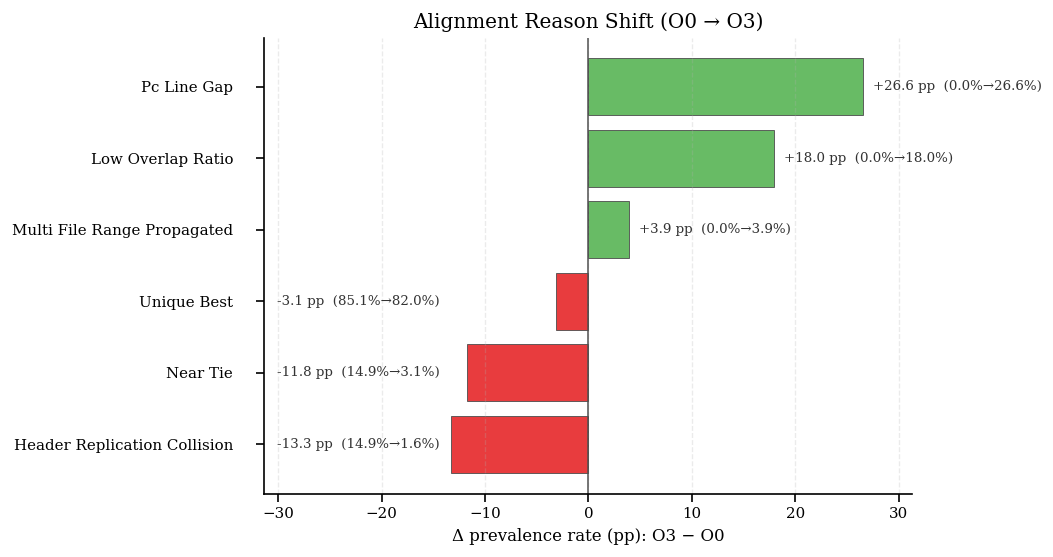

In [5]:
## ── Plot 1: Reason Shift Δpp (diverging bar) ─────────────────────────────────

reason_df = compute_reason_shift(df_report, opt_a=OPT_A, opt_b=OPT_B, top_k=6)

if reason_df.empty:
    print("⚠ No reason data available")
else:
    fig, ax = plt.subplots(figsize=(9, 5))

    y = np.arange(len(reason_df))
    vals = reason_df["delta_pp"].values.astype(float)
    colors = np.where(vals >= 0, "#4daf4a", "#e41a1c") #type: ignore

    ax.barh(y, vals, color=colors, edgecolor="0.3", linewidth=0.6, alpha=0.85) #type: ignore
    ax.axvline(0, color="0.3", linewidth=0.9)

    ax.set_yticks(y)
    ax.set_yticklabels(reason_df["reason"].values, fontsize=9)
    ax.tick_params(axis="y", pad=14)

    ax.set_xlabel(f"Δ prevalence rate (pp): {OPT_B} − {OPT_A}")
    ax.set_title(f"Alignment Reason Shift ({OPT_A} → {OPT_B})")

    max_abs = float(np.max(np.abs(vals))) if len(vals) else 1.0
    xpad = max(3.0, max_abs * 0.18)
    ax.set_xlim(-max_abs - xpad, max_abs + xpad)

    fig.subplots_adjust(left=0.38, right=0.98, top=0.90, bottom=0.14)

    # Annotations: delta + share at each level
    xmin, xmax = ax.get_xlim()
    x_range = xmax - xmin
    neg_x = xmin + 0.02 * x_range
    pos_pad = 0.015 * x_range

    share_a_col = f"share_{OPT_A}"
    share_b_col = f"share_{OPT_B}"
    for i, (_, row) in enumerate(reason_df.iterrows()):
        d = row["delta_pp"]
        a0 = row[share_a_col]
        a1 = row[share_b_col]
        label = f"{d:+.1f} pp  ({a0:.1f}%→{a1:.1f}%)"
        if d >= 0:
            ax.text(d + pos_pad, i, label,
                    va="center", ha="left", fontsize=8, color="0.2", clip_on=False)
        else:
            ax.text(neg_x, i, label,
                    va="center", ha="left", fontsize=8, color="0.2", clip_on=False)

    if "Other" in reason_df["reason"].values:
        ax.text(0.99, 0.01, "Top-6 reasons shown; remainder folded into 'Other'.",
                transform=ax.transAxes, ha="right", va="bottom", fontsize=8, color="0.35")

    ax.grid(axis="x", linestyle="--", alpha=0.25)

    save_fig("03_reason_shift_delta_pp")
    plt.show()

---
## Plot 2 — Overlap Ratio ECDF

**What it shows:** The cumulative distribution of `overlap_ratio` for oracle-accepted
functions (ACCEPT or WARN verdict) at each optimization level.

**How it's computed:**

- `overlap_ratio = overlap_count / total_count` — the fraction of DWARF
  line rows in the function's address range that map to the best tree-sitter
  candidate. It comes directly from the joiner, not computed here.
- We filter to `dwarf_verdict ∈ {ACCEPT, WARN}` to include only functions that
  the oracle considered targetable. This excludes REJECT functions (which
  never entered alignment).
- The ECDF (Empirical Cumulative Distribution Function) sorts all overlap_ratio
  values and plots: x = overlap_ratio, y = fraction of functions with value ≤ x.

The vertical dashed line marks the joiner's `MIN_OVERLAP_RATIO` threshold
(imported from pipeline configuration) — functions below this get verdict
NO_MATCH.

**Why it matters:** Shift to the left = more functions with degraded overlap = 
less reliable ground truth at that opt level.

  → saved ..\..\figures\oracle_analysis\04_overlap_ratio_ecdf.{pdf,png}


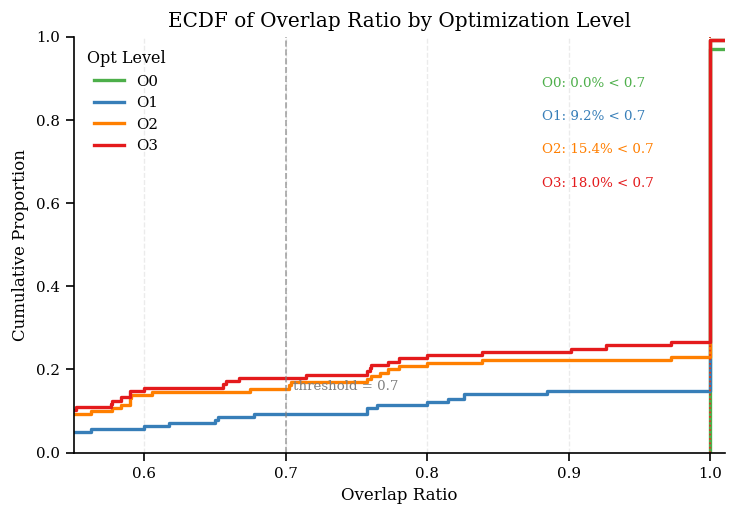

In [6]:
## ── Plot 2: Overlap Ratio ECDF ───────────────────────────────────────────────

targetable = {OracleVerdict.ACCEPT.value, OracleVerdict.WARN.value}
df_valid = df_pairs[df_pairs["dwarf_verdict"].isin(targetable)].copy()

fig, ax = plt.subplots(figsize=(7, 4.5))

y_annot = 0.88
for opt in OPT_LEVELS:
    subset = df_valid[df_valid["opt"] == opt]
    if subset.empty:
        continue

    sns.ecdfplot(data=subset, x="overlap_ratio", ax=ax,
                 label=opt, color=OPT_COLORS[opt], linewidth=2)

    p_below = (subset["overlap_ratio"] < MIN_OVERLAP_RATIO).mean() * 100
    ax.text(0.72, y_annot, f"{opt}: {p_below:.1f}% < {MIN_OVERLAP_RATIO}",
            fontsize=8, color=OPT_COLORS[opt], transform=ax.transAxes)
    y_annot -= 0.08

    med = subset["overlap_ratio"].median()
    ax.axvline(med, color=OPT_COLORS[opt], linestyle=":", linewidth=1, alpha=0.8)

ax.axvline(MIN_OVERLAP_RATIO, color="gray", linestyle="--", linewidth=1, alpha=0.7)
ax.text(MIN_OVERLAP_RATIO + 0.005, 0.15,
        f"threshold = {MIN_OVERLAP_RATIO}", fontsize=8, color="gray")

ax.set_xlabel("Overlap Ratio")
ax.set_ylabel("Cumulative Proportion")
ax.set_title("ECDF of Overlap Ratio by Optimization Level")
ax.legend(title="Opt Level", frameon=False)
ax.set_xlim(max(0, MIN_OVERLAP_RATIO - 0.15), 1.01)
ax.grid(axis="x", linestyle="--", alpha=0.25)

save_fig("04_overlap_ratio_ecdf")
plt.show()

---
## Plot 3 — Decision Space Scatter (Overlap vs Gap)

**What it shows:** Each aligned pair as a point in 2D space:
x = gap_count, y = overlap_ratio. The plot reveals the joint distribution
of these two alignment quality indicators across all loaded optimization levels.

**How the axes are computed:**

- `gap_count = total_count − overlap_count` — the number of DWARF line rows
  inside the function's address range that do *not* map to the best tree-sitter
  candidate. These are "leaked" rows from inlined code.
- `overlap_ratio = overlap_count / total_count` — fraction of rows that *do* map.

Note: `gap_count` and `overlap_ratio` are algebraically related
(`overlap_ratio = 1 − gap_count/total_count`), but plotting both reveals how
function *size* (total_count) mediates the relationship. A function with 100
total rows and 5 gaps looks different from one with 10 rows and 5 gaps.

**Visual encodings:**
- Color = alignment verdict (MATCH / AMBIGUOUS / NO_MATCH)
- Marker shape = optimization level
- Point size ∝ `total_count` (larger functions = bigger points)
- Per-opt P90 gap lines mark the 90th percentile of gap severity

  → saved ..\..\figures\oracle_analysis\06_scatter_overlap_vs_gap.{pdf,png}


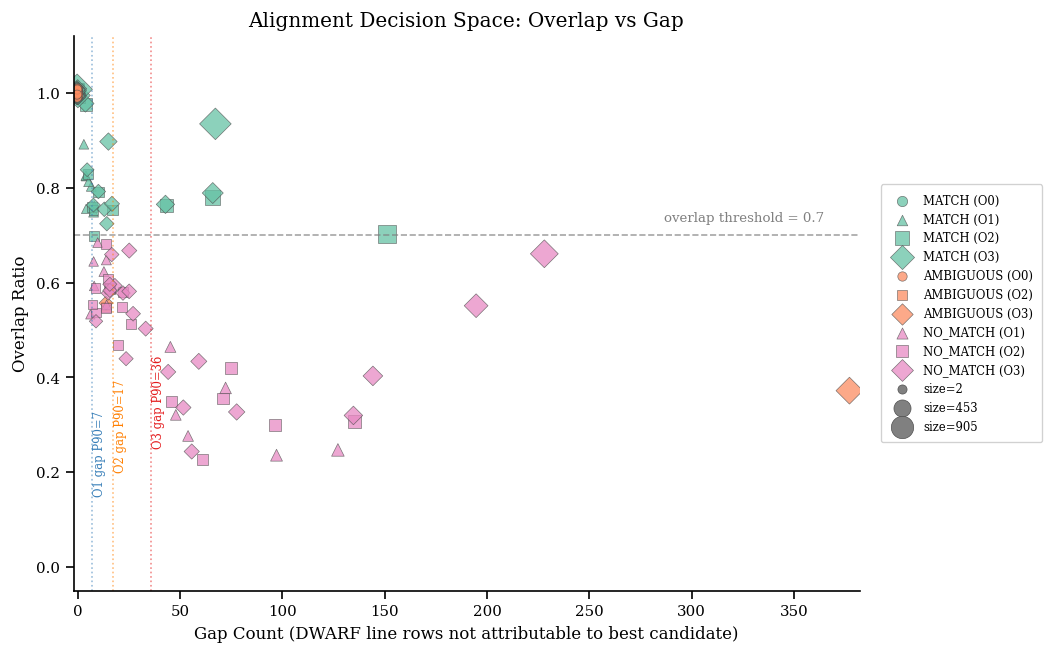

In [ ]:
## ── Plot 3: Scatter — overlap_ratio vs gap_count ─────────────────────────────
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(10, 6))
rng = np.random.default_rng(42)

x_max = df_pairs["gap_count"].max() + 5 if not df_pairs.empty else 15
ax.set_xlim(-2, x_max)
ax.set_ylim(-0.05, 1.12)

# ── Scatter points ───────────────────────────────────────────────────────────
tc_vals = df_pairs["total_count"].values.astype(float)
tc_min, tc_max = (tc_vals.min(), tc_vals.max()) if len(tc_vals) else (0, 1)  # type: ignore
size_scale = (
    (lambda v: 30 + 150 * (v - tc_min) / (tc_max - tc_min))
    if tc_max > tc_min else (lambda v: 50)
)

for verdict in [AlignmentVerdict.MATCH.value,
                AlignmentVerdict.AMBIGUOUS.value,
                AlignmentVerdict.NO_MATCH.value]:
    for opt in OPT_LEVELS:
        mask = (df_pairs["verdict"] == verdict) & (df_pairs["opt"] == opt)
        sub = df_pairs[mask]
        if sub.empty:
            continue
        jx = rng.uniform(-0.35, 0.35, size=len(sub))
        jy = rng.uniform(-0.01, 0.01, size=len(sub))
        sizes = np.array([size_scale(v) for v in sub["total_count"].values])
        ax.scatter(
            sub["gap_count"].values + jx,  # type: ignore
            sub["overlap_ratio"].values + jy,  # type: ignore
            c=PALETTE_VERDICT[verdict], marker=OPT_MARKERS[opt],
            s=sizes, alpha=0.75, edgecolors="0.3", linewidths=0.4,
            label=f"{verdict} ({opt})",
        )

# ── Threshold lines ──────────────────────────────────────────────────────────
ax.axhline(MIN_OVERLAP_RATIO, color="gray", linestyle="--", linewidth=1, alpha=0.7)
ax.text(x_max * 0.75, MIN_OVERLAP_RATIO + 0.03,
        f"overlap threshold = {MIN_OVERLAP_RATIO}", fontsize=8, color="gray")

# Per-opt P90 gap line
for opt in OPT_LEVELS:
    sub = df_pairs[df_pairs["opt"] == opt]
    if sub.empty:
        continue
    gap_p90 = sub["gap_count"].quantile(0.90)
    if gap_p90 > 0:
        ax.axvline(gap_p90, color=OPT_COLORS[opt], linestyle=":", linewidth=1, alpha=0.5)
        ax.text(gap_p90 + 0.5, 0.10 + 0.05 * OPT_LEVELS.index(opt),
                f"{opt} gap P90={gap_p90:.0f}",
                fontsize=7, color=OPT_COLORS[opt], rotation=90, va="bottom")

ax.set_xlabel("Gap Count (DWARF line rows not attributable to best candidate)")
ax.set_ylabel("Overlap Ratio")
ax.set_title("Alignment Decision Space: Overlap vs Gap")

# ── Legend (outside the plot area) ───────────────────────────────────────────
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Size legend
if tc_max > tc_min:
    for ref_val, lbl in [(int(tc_min), "small"), (int((tc_min+tc_max)/2), "med"),
                         (int(tc_max), "large")]:
        by_label[f"size={ref_val}"] = plt.scatter(
            [], [], c="0.5", s=size_scale(ref_val), edgecolors="0.3", linewidths=0.4)

ax.legend(by_label.values(), by_label.keys(), fontsize=7, frameon=True,
          facecolor="white", edgecolor="0.8", framealpha=0.9,
          ncol=1, loc="center left", bbox_to_anchor=(1.02, 0.5),
          borderpad=0.8, columnspacing=1)

fig.subplots_adjust(right=0.78)

save_fig("06_scatter_overlap_vs_gap")
plt.show()